<a href="https://colab.research.google.com/github/kristinazk/HomeWorkWeek17/blob/main/adversarialHw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


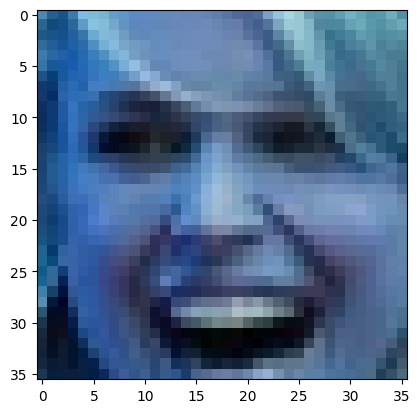

In [2]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

In [4]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE], name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8, 8, 10)))
generator.add(L.Conv2DTranspose(64, kernel_size=(5, 5), activation='elu'))

generator.add(L.Conv2DTranspose(64, kernel_size=(5, 5), activation='elu'))

generator.add(L.UpSampling2D(size=(2, 2)))
generator.add(L.Conv2DTranspose(32, kernel_size=3, activation='elu'))

generator.add(L.Conv2DTranspose(32, kernel_size=3, activation='elu'))
generator.add(L.Conv2DTranspose(32, kernel_size=3, activation='elu'))
generator.add(L.Conv2D(3, kernel_size=3, activation=None))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 640)               164480    
                                                                 
 reshape (Reshape)           (None, 8, 8, 10)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 64)       16064     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       102464    
 ranspose)                                                       
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                        

In [5]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

In [6]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

discriminator.add(L.Conv2D(8, kernel_size=3, activation='elu'))
discriminator.add(L.Dropout(0.25))
discriminator.add(L.AveragePooling2D(pool_size=(2, 2)))

discriminator.add(L.Conv2D(16, kernel_size=3, activation='elu'))
discriminator.add(L.AveragePooling2D(pool_size=(2, 2)))

discriminator.add(L.Conv2D(32, kernel_size=3, activation='elu'))
discriminator.add(L.AveragePooling2D(pool_size=(2, 2)))

discriminator.add(L.Flatten())
discriminator.add(L.Dense(64, activation='tanh'))
discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))


In [7]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow, ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

1/1 [==============================] - 0s 323ms/step


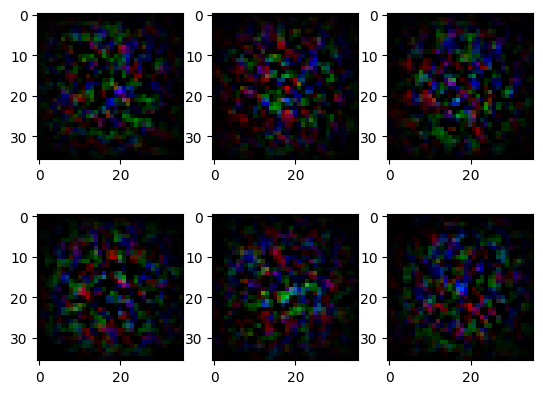

32/32 [==============================] - 0s 2ms/step


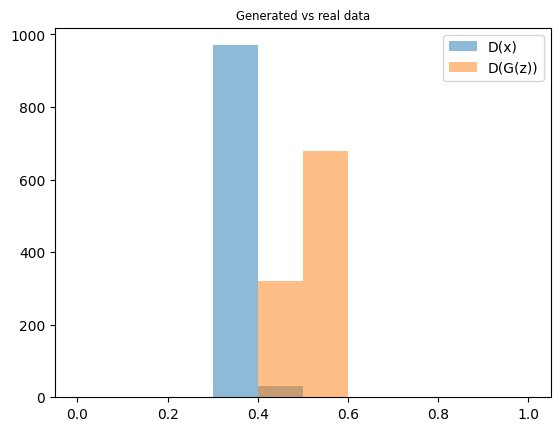

1
Discriminator loss:  tf.Tensor(-0.62697387, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(-0.6273401, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(-0.6277062, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(-0.62807226, shape=(), dtype=float32)
Generator loss:  tf.Tensor(-1.683931, shape=(), dtype=float32)
2
Discriminator loss:  tf.Tensor(-0.6624656, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(-0.66278255, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(-0.6630993, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(-0.663416, shape=(), dtype=float32)
Generator loss:  tf.Tensor(-1.7155854, shape=(), dtype=float32)
3
Discriminator loss:  tf.Tensor(-0.6977785, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(-0.69806445, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(-0.6983503, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(-0.69863605, shape=(), dtype=float32)
Generator loss:  tf.Tensor(-1.7484568, shape=()

In [ ]:
from IPython import display
from tqdm import tnrange

disc_optimizer = tf.optimizers.SGD(learning_rate=1e-5)
gen_optimizer = tf.optimizers.Adam(learning_rate=1e-4)


for epoch in tnrange(50000):
    real_data = sample_data_batch(100)
    noise = sample_noise_batch(100)

    print(epoch)

    if epoch < 1000:
      n = 4
    elif 5000 > epoch >= 1000:
      n = 3
    elif 38000 > epoch >= 5000:
      n = 2
    else:
      n = 1

    ########################
    # discriminator training
    ########################
    for _ in range(n):
        with tf.GradientTape() as disc_tape:
            logp_real = (discriminator(real_data))

            generated_data = generator(noise)

            logp_gen = (1 - discriminator(generated_data))

            d_loss = -tf.reduce_mean(logp_real[:, 1] + logp_gen[:, 1])

            # regularize
            d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

        # optimize
        disc_optimizer.minimize(
          d_loss,
          var_list=discriminator.trainable_variables,
          tape=disc_tape
    )
        print("Discriminator loss: ", d_loss)

    ########################
    # generator training
    ########################

    for _ in range(1):
      with tf.GradientTape() as gen_tape:
          logp_gen = (1 - discriminator(generator(noise)))

          g_loss = -tf.reduce_mean(logp_gen[:, 1])

      # optimize
      gen_optimizer.minimize(
          g_loss,
          var_list=generator.trainable_variables,
          tape=gen_tape
      )
      print("Generator loss: ", g_loss)

    if epoch % 100 == 0:
        display.clear_output(wait=True)
        sample_images(2, 3, True)
        sample_probas(1000)

In [ ]:
plt.figure(figsize=[16,24])
sample_images(16,8)